###**Andrew Renninger**
### Homework Three

**Packages**

In [0]:
!pip install tifffile

In [0]:
import sys
import numpy as np
import pandas as pd
import os

from skimage.transform import resize

import pickle
import matplotlib
import matplotlib.pyplot as plt

from sklearn import cluster

import matplotlib.pyplot as plt

from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold

from sklearn.utils import shuffle

from sklearn import preprocessing

**Directories**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

BDIR = '/content/drive/My Drive/PrjData/Prj_EuroSat/Out/Data_p20_c2-4-5-8-9'
listImg = BDIR + '/ListImages_p20_c2-4-5-8-9.csv'

**Functions**

In [0]:

def scaleImgPerc(imgIn, percLow, percHigh):
    if len(imgIn.shape) == 2:
        imgIn = imgIn.reshape([imgIn.shape[0], imgIn.shape[1], 1])
        
    w, h, d = imgIn.shape
    imgIn = np.reshape(imgIn, [w * h, d]).astype(np.float64)
    mins = np.percentile(imgIn, percLow, axis=0)
    ranges = np.percentile(imgIn, percHigh, axis=0) - mins
    imgIn = (imgIn - mins[None, :]) / ranges[None, :]
    imgIn = np.reshape(imgIn, [w, h, d])
    imgIn = imgIn.clip(0, 1)
    return imgIn

def imgToFeatVec(imgIn):
    dataMat = pickle.load(open(imgIn, "rb"))
    dataMat = dataMat[:,:,0].squeeze().flatten()
    return dataMat

### S1:
- Load EuroSat data
- Visualize few images to check the multi-channel images and labels

- Q: What is the number of images in this dataset: **2700**

- Q: What is the number of labels in this dataset: **5 unique labels ('Forest', 'Highway', 'Industrial', 'Residential', 'River')**

- Q: What is the size of each image in this dataset: **64 x 64 (by 13 bands)**

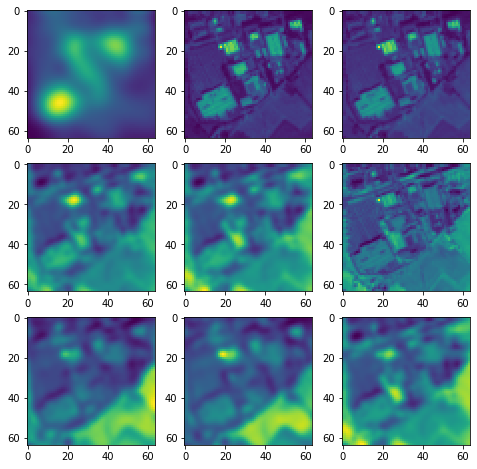

In [6]:
tmp = BDIR + '/ImagesMat/Industrial_712.p'
tmpMat = pickle.load(open(tmp, "rb"))

imgSize = tmpMat[:, :, 1].shape

fig, axs = plt.subplots(3, 3, figsize = [8, 8])
for i in np.arange(0, 3):
    for j in np.arange(0, 3):
        idx = i*5+j
        pImg = np.array(tmpMat[:, :, idx]).reshape(imgSize)
        axs[i, j].imshow(pImg)
        
plt.show()

In [7]:
df = pd.read_csv(listImg)
df['MatName'] = BDIR + '/ImagesMat/' + df.ImgName + '.p'

df.head()

,CNO,CType,ImgName,ImgPath,MatName
0,2,Forest,Forest_2967,../Data/sentinel_2/tif/Forest/Forest_2967.tif,/content/drive/My Drive/PrjData/Prj_EuroSat/Ou...
1,2,Forest,Forest_845,../Data/sentinel_2/tif/Forest/Forest_845.tif,/content/drive/My Drive/PrjData/Prj_EuroSat/Ou...
2,2,Forest,Forest_296,../Data/sentinel_2/tif/Forest/Forest_296.tif,/content/drive/My Drive/PrjData/Prj_EuroSat/Ou...
3,2,Forest,Forest_531,../Data/sentinel_2/tif/Forest/Forest_531.tif,/content/drive/My Drive/PrjData/Prj_EuroSat/Ou...
4,2,Forest,Forest_2394,../Data/sentinel_2/tif/Forest/Forest_2394.tif,/content/drive/My Drive/PrjData/Prj_EuroSat/Ou...


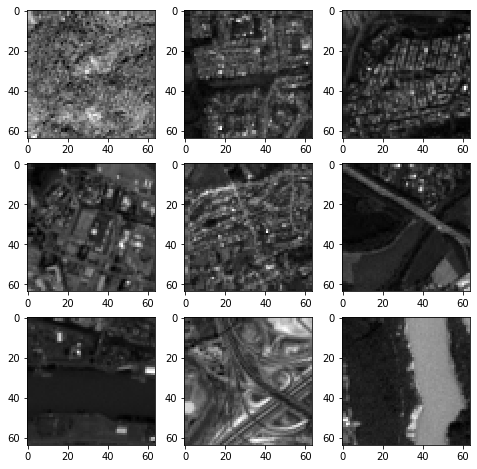

In [8]:
idx = np.random.randint(0, 2701, 9)

fig, axs = plt.subplots(3, 3, figsize = [8, 8])
for i in np.arange(0, 3):
    for j in np.arange(0, 3):
      ind = i*3+j
      imgPath = df.MatName[idx[ind]]
      imgMat = pickle.load(open(imgPath, "rb"))
      axs[i, j].imshow(imgMat[:, :, 1], cmap = 'gray')
        
plt.show()

### S2:
- Create data matrixes X and y as follows:
  - Define L1: a list of labels for class 0 (example: 5 and 8)
  - Define L2: a list of labels for class 1 (example: 2, 6 and 7)
  - Define CH: a list of image channels used (example: 7)
  - Select all images for labels in L1 and L2
  - Extract only channels in CH from each selected image and flatten them to a feature matrix X
  - Create the labels y (with binary labels 0 and 1) 
- Q: What is the size of X:   **1100 x 16384 (though this will be unique to the classes chosen)**
- Q: What is the size of y:   **1100**

In [9]:
L0 = 'Forest'
L1 = 'Highway'

df['CAT'] = 999
df.loc[df.CType == L0, 'CAT'] = 0
df.loc[df.CType == L1, 'CAT'] = 1

sel = df[df['CAT'] != 999]

sel.head()

,CNO,CType,ImgName,ImgPath,MatName,CAT
0,2,Forest,Forest_2967,../Data/sentinel_2/tif/Forest/Forest_2967.tif,/content/drive/My Drive/PrjData/Prj_EuroSat/Ou...,0
1,2,Forest,Forest_845,../Data/sentinel_2/tif/Forest/Forest_845.tif,/content/drive/My Drive/PrjData/Prj_EuroSat/Ou...,0
2,2,Forest,Forest_296,../Data/sentinel_2/tif/Forest/Forest_296.tif,/content/drive/My Drive/PrjData/Prj_EuroSat/Ou...,0
3,2,Forest,Forest_531,../Data/sentinel_2/tif/Forest/Forest_531.tif,/content/drive/My Drive/PrjData/Prj_EuroSat/Ou...,0
4,2,Forest,Forest_2394,../Data/sentinel_2/tif/Forest/Forest_2394.tif,/content/drive/My Drive/PrjData/Prj_EuroSat/Ou...,0


Here is a modified function for reading in images, this time accepting an input of channels. 

In [0]:
def imgToFeatVec(imgIn, channels):
    dataMat = pickle.load(open(imgIn, "rb"))
    dataMat = dataMat[:,:, channels].squeeze().flatten()
    return dataMat

We set up the channels or bands we are interested in using here: Blue, Green, Red, and Infrared (a signature of plants), which should help distinguish highways from forests. 

In [0]:
CH = [1, 2, 3, 7]

featVecSize = imgToFeatVec(sel.MatName[0], CH).shape[0]
dataMat = np.zeros([sel.shape[0], featVecSize])

for i, tmpRow in sel.iterrows():
    dataMat[i,:] = imgToFeatVec(tmpRow.MatName, CH)
    
labels = np.array(sel.CAT)

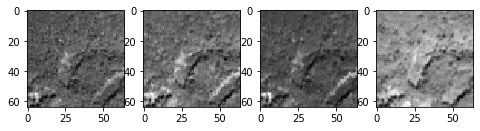

In [12]:
dims = pickle.load(open(sel.MatName[0], "rb"))
dims = dims[:,:, CH].shape

tImg = np.array(dataMat[0]).reshape(dims)

fig, axs = plt.subplots(1, 4, figsize = [8, 8])

for i in np.arange(0, 4):
    axs[i].imshow(tImg[:, :, i], cmap = 'gray')

plt.show()

In [13]:
print(dataMat.shape)
print(labels.shape)

(1100, 16384)
(1100,)


### S3:
- Using X and y create a split dataset with 60% training and 40% testing data with similar distributions for the two classes
- Train a linear SVM classifier on the training data and run it on the testing data
- Draw the ROC for the classification 
- Q: What is the training accuracy? **100 (overfit with more features than cases)**
- Q: What is the testing accuracy? **89.5**
- Q: What is the AUC? **99 / 96 / 97 / 98 / 98 / 99 across six folds**

In [0]:
indPos = np.where(labels == 1)[0]
indNeg = shuffle(np.where(labels == 0)[0], random_state = 42)[0:indPos.shape[0]]

indBal = shuffle(np.concatenate([indPos, indNeg]), random_state = 42)

XBal = dataMat[indBal, :]
YBal = labels[indBal]

scaler = preprocessing.StandardScaler().fit(XBal)
XBalSc = scaler.transform(XBal)

X_train, X_test, y_train, y_test = train_test_split(XBalSc, YBal, stratify = YBal, train_size = 0.6, random_state = 42)

In [15]:
print('Train size: ' + str(y_train.shape[0]))
svc = SVC(kernel = 'linear')

print('Training the model ...')
svc.fit(X_train, y_train)

print('Applying the model ...')
yPred_1 = svc.predict(X_train)
yPred_2 = svc.predict(X_test)

print('Training accuracy: ' + str(100 * np.sum(yPred_1 == y_train) / y_train.shape[0]))
print('Testing accuracy: ' + str(100 * np.sum(yPred_2 == y_test) / y_test.shape[0]))

Train size: 600
Training the model ...
Applying the model ...
Training accuracy: 100.0
Testing accuracy: 89.5


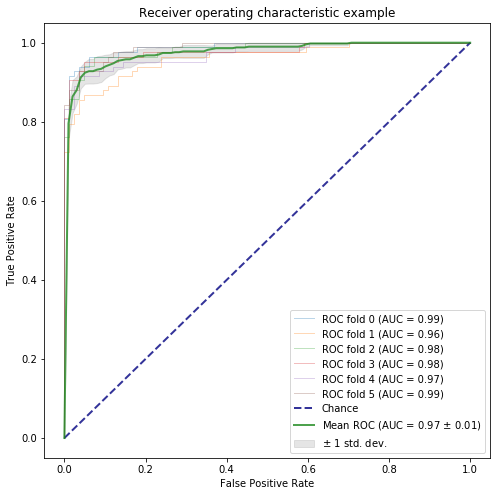

In [16]:
from scipy import interp
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits = 6)
classifier = SVC(kernel = 'linear', probability = True)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

X = XBalSc
y = YBal

fig, ax = plt.subplots(figsize = [8, 8])
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='navy',
        label='Chance', alpha= 0.8)

mean_tpr = np.mean(tprs, axis = 0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color = 'forestgreen',
        label = r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw = 2, alpha = 0.8)

std_tpr = np.std(tprs, axis = 0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color = 'grey', alpha = 0.2,
                label = r'$\pm$ 1 std. dev.')

ax.set(xlim = [-0.05, 1.05], ylim = [-0.05, 1.05],
       title = "Receiver operating characteristic example")
ax.legend(loc = "lower right")
plt.show()

### S4:
- Repeat steps S2 and S3 to create a classifier that classifies Industrial vs Residential
- Q: What is the training accuracy? **100**
- Q: What is the testing accuracy? **81.5**
- Q: What is the AUC? **87 / 87 / 83 / 87 / 89 / 87 across six folds**

In [17]:
L0 = 'Residential'
L1 = 'Industrial'

df['CAT'] = 999
df.loc[df.CType == L0, 'CAT'] = 0
df.loc[df.CType == L1, 'CAT'] = 1

sel = df[df['CAT'] != 999].reset_index(drop = True)

sel.head()

,CNO,CType,ImgName,ImgPath,MatName,CAT
0,5,Industrial,Industrial_846,../Data/sentinel_2/tif/Industrial/Industrial_8...,/content/drive/My Drive/PrjData/Prj_EuroSat/Ou...,1
1,5,Industrial,Industrial_1124,../Data/sentinel_2/tif/Industrial/Industrial_1...,/content/drive/My Drive/PrjData/Prj_EuroSat/Ou...,1
2,5,Industrial,Industrial_770,../Data/sentinel_2/tif/Industrial/Industrial_7...,/content/drive/My Drive/PrjData/Prj_EuroSat/Ou...,1
3,5,Industrial,Industrial_1223,../Data/sentinel_2/tif/Industrial/Industrial_1...,/content/drive/My Drive/PrjData/Prj_EuroSat/Ou...,1
4,5,Industrial,Industrial_815,../Data/sentinel_2/tif/Industrial/Industrial_8...,/content/drive/My Drive/PrjData/Prj_EuroSat/Ou...,1


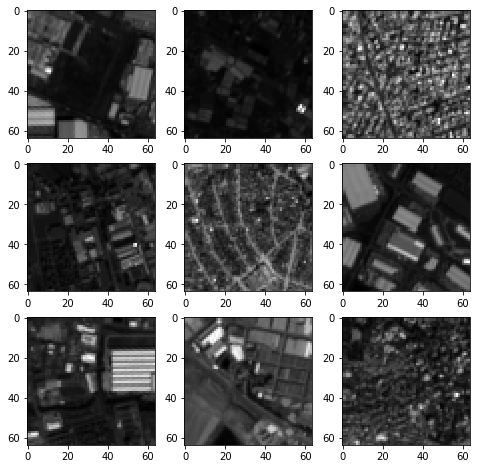

In [18]:
idx = np.random.randint(0, sel.shape[0], 9)

fig, axs = plt.subplots(3, 3, figsize = [8, 8])
for i in np.arange(0, 3):
    for j in np.arange(0, 3):
      ind = i*3+j
      imgPath = sel.MatName[idx[ind]]
      imgMat = pickle.load(open(imgPath, "rb"))
      axs[i, j].imshow(imgMat[:, :, 2], cmap = 'gray')
        
plt.show()

Buildings are associated with shortwave infrared and infrared, so we will include those in this study.

In [0]:
CH = [2, 7, 10]

featVecSize = imgToFeatVec(sel.MatName[0], CH).shape[0]
dataMat = np.zeros([sel.shape[0], featVecSize])

for i, tmpRow in sel.iterrows():
    dataMat[i,:] = imgToFeatVec(tmpRow.MatName, CH)
    
labels = np.array(sel.CAT)

In [0]:
indPos = np.where(labels == 1)[0]
indNeg = shuffle(np.where(labels == 0)[0], random_state = 42)[0:indPos.shape[0]]

indBal = shuffle(np.concatenate([indPos, indNeg]), random_state = 42)

XBal = dataMat[indBal, :]
YBal = labels[indBal]

scaler = preprocessing.StandardScaler().fit(XBal)
XBalSc = scaler.transform(XBal)

X_train, X_test, y_train, y_test = train_test_split(XBalSc, YBal, stratify = YBal, train_size = 0.6, random_state = 42)

In [21]:
print('Train size: ' + str(y_train.shape[0]))
svc = SVC(kernel = 'linear')

print('Training the model ...')
svc.fit(X_train, y_train)

print('Applying the model ...')
yPred_1 = svc.predict(X_train)
yPred_2 = svc.predict(X_test)

print('Training accuracy: ' + str(100 * np.sum(yPred_1 == y_train) / y_train.shape[0]))
print('Testing accuracy: ' + str(100 * np.sum(yPred_2 == y_test) / y_test.shape[0]))

Train size: 600
Training the model ...
Applying the model ...
Training accuracy: 100.0
Testing accuracy: 81.5


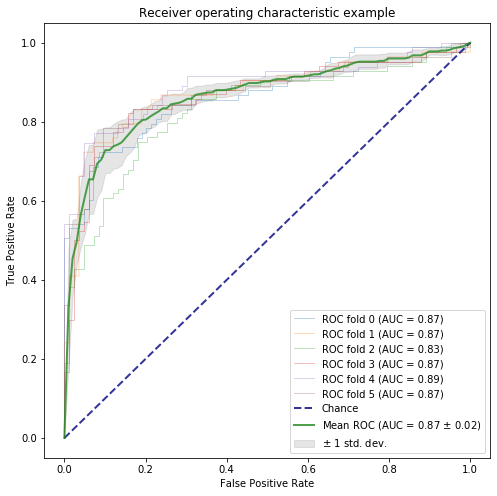

In [22]:
cv = StratifiedKFold(n_splits = 6)
classifier = SVC(kernel = 'linear', probability = True)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

X = XBalSc
y = YBal

fig, ax = plt.subplots(figsize = [8, 8])
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='navy',
        label='Chance', alpha= 0.8)

mean_tpr = np.mean(tprs, axis = 0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color = 'forestgreen',
        label = r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw = 2, alpha = 0.8)

std_tpr = np.std(tprs, axis = 0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color = 'grey', alpha = 0.2,
                label = r'$\pm$ 1 std. dev.')

ax.set(xlim = [-0.05, 1.05], ylim = [-0.05, 1.05],
       title = "Receiver operating characteristic example")
ax.legend(loc = "lower right")
plt.show()

### S5:
- Repeat steps S4 using all image channels as input
- Q: What is the training accuracy? **92.6**
- Q: What is the testing accuracy? **82.5**
- Q: What is the AUC? **89 / 86 / 87 / 90 / 90 / 91 across six folds**

In [0]:
def imgToFeatVec(imgIn):
    dataMat = pickle.load(open(imgIn, "rb"))
    dataMat = dataMat[:, :, :].squeeze().flatten()
    return dataMat

We recast the function one more time to include all bands.

In [0]:
featVecSize = imgToFeatVec(sel.MatName[0]).shape[0]
dataMat = np.zeros([sel.shape[0], featVecSize])

for i, tmpRow in sel.iterrows():
    dataMat[i,:] = imgToFeatVec(tmpRow.MatName)
    
labels = np.array(sel.CAT)

So many dimensions feels a rather crass so I decided to PCA here—hoping it is still within the spirit of the question.

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

NUM_COMP = 100

This all gives me the opportunity to scale the data, rather than using the raw numbers. 

In [0]:
scaler = StandardScaler()
scaler.fit(dataMat)
X = scaler.transform(dataMat)

In [28]:
pca = PCA(n_components = NUM_COMP)
pcaMdl = pca.fit(X)
pcaCoor = pcaMdl.transform(X)

print(pcaCoor.shape)

(1100, 100)


In [0]:
indPos = np.where(labels == 1)[0]
indNeg = shuffle(np.where(labels == 0)[0], random_state = 42)[0:indPos.shape[0]]

indBal = shuffle(np.concatenate([indPos, indNeg]), random_state = 42)

XBal = pcaCoor[indBal, :]
YBal = labels[indBal]

scaler = preprocessing.StandardScaler().fit(XBal)
XBalSc = scaler.transform(XBal)

X_train, X_test, y_train, y_test = train_test_split(XBalSc, YBal, stratify = YBal, train_size = 0.6, random_state = 42)

In [30]:
print('Train size: ' + str(y_train.shape[0]))
svc = SVC(kernel = 'linear')

print('Training the model ...')
svc.fit(X_train, y_train)

print('Applying the model ...')
yPred_1 = svc.predict(X_train)
yPred_2 = svc.predict(X_test)

print('Training accuracy: ' + str(100 * np.sum(yPred_1 == y_train) / y_train.shape[0]))
print('Testing accuracy: ' + str(100 * np.sum(yPred_2 == y_test) / y_test.shape[0]))

Train size: 600
Training the model ...
Applying the model ...
Training accuracy: 92.5
Testing accuracy: 81.25


PCA seems to be more generalizable than the overfit option above. 

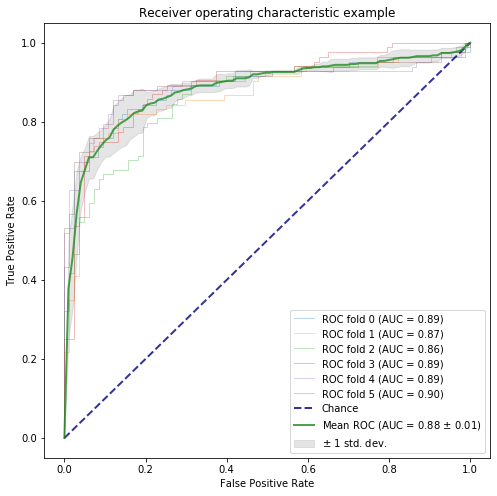

In [31]:
cv = StratifiedKFold(n_splits = 6)
classifier = SVC(kernel = 'linear', probability = True)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

X = XBalSc
y = YBal

fig, ax = plt.subplots(figsize = [8, 8])
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='navy',
        label='Chance', alpha= 0.8)

mean_tpr = np.mean(tprs, axis = 0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color = 'forestgreen',
        label = r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw = 2, alpha = 0.8)

std_tpr = np.std(tprs, axis = 0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color = 'grey', alpha = 0.2,
                label = r'$\pm$ 1 std. dev.')

ax.set(xlim = [-0.05, 1.05], ylim = [-0.05, 1.05],
       title = "Receiver operating characteristic example")
ax.legend(loc = "lower right")
plt.show()

### S6:
- Repeat S4 with leave-10%-out cross validation
- Q: What is the training accuracy? **90.5**
- Q: What is the testing accuracy? **84.3**
- Q: What is the AUC? **90 mean across 10 folds** 

(I did this section a little differently to experiment and I did not set a seed so the results will vary.)

In [32]:
trains = []
tests = []

for i in np.arange(1, 10):
    indPos = np.where(labels == 1)[0]
    indNeg = shuffle(np.where(labels == 0)[0])[0:indPos.shape[0]]

    indBal = shuffle(np.concatenate([indPos, indNeg]))

    XBal = pcaCoor[indBal, :]
    YBal = labels[indBal]

    scaler = preprocessing.StandardScaler().fit(XBal)
    XBalSc = scaler.transform(XBal)

    X_train, X_test, y_train, y_test = train_test_split(XBalSc, YBal, stratify = YBal, train_size = 0.9)
    
    svc = SVC(kernel='linear')

    svc.fit(X_train, y_train)

    yPred_1 = svc.predict(X_train)
    yPred_2 = svc.predict(X_test)
    
    trainacc = 100 * np.sum(yPred_1 == y_train) / y_train.shape[0]
    testacc = 100 * np.sum(yPred_2 == y_test) / y_test.shape[0]

    trains.append(trainacc)
    tests.append(testacc)

print("Trianing accuracy: " + str(np.mean(trains)))
print("Training st. dev: " + str(np.std(trains)))

print("Testing accuracy: " + str(np.mean(tests)))
print("Testing st. dev: " + str(np.std(tests)))

Trianing accuracy: 90.5679012345679
Training st. dev: 0.6316838916279544
Testing accuracy: 83.44444444444444
Testing st. dev: 2.165954298846436


Leave 10% out *should* be consistent with 10 folds. 

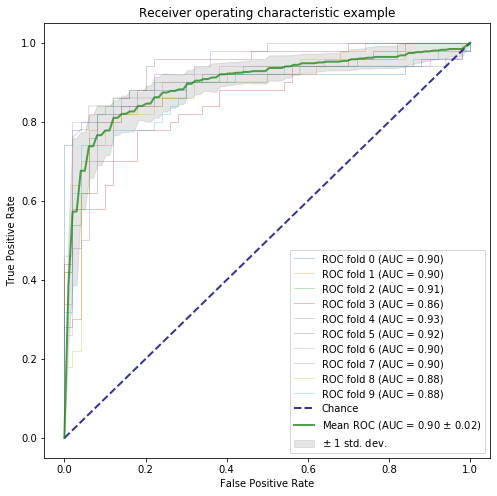

In [33]:
cv = StratifiedKFold(n_splits = 10)
classifier = SVC(kernel = 'linear', probability = True)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

X = XBalSc
y = YBal

fig, ax = plt.subplots(figsize = [8, 8])
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='navy',
        label='Chance', alpha= 0.8)

mean_tpr = np.mean(tprs, axis = 0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color = 'forestgreen',
        label = r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw = 2, alpha = 0.8)

std_tpr = np.std(tprs, axis = 0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color = 'grey', alpha = 0.2,
                label = r'$\pm$ 1 std. dev.')

ax.set(xlim = [-0.05, 1.05], ylim = [-0.05, 1.05],
       title = "Receiver operating characteristic example")
ax.legend(loc = "lower right")
plt.show()

### S7: 
- Repeat S2 and S3 to implement a binary classifier between "Residential + Industrial" vs "Others"
- Q: What is the training accuracy? **100**
- Q: What is the testing accuracy? **75.11**
- Q: What is the AUC? **83 mean across 6 folds**

In [34]:
SEL_LABEL = ['Residential', 'Industrial']

df['CAT'] = 0
df.loc[(df.CType == SEL_LABEL[0]) | (df.CType == SEL_LABEL[1]), 'CAT'] = 1

sel = df[df['CAT'] != 999]

sel.head()

,CNO,CType,ImgName,ImgPath,MatName,CAT
0,2,Forest,Forest_2967,../Data/sentinel_2/tif/Forest/Forest_2967.tif,/content/drive/My Drive/PrjData/Prj_EuroSat/Ou...,0
1,2,Forest,Forest_845,../Data/sentinel_2/tif/Forest/Forest_845.tif,/content/drive/My Drive/PrjData/Prj_EuroSat/Ou...,0
2,2,Forest,Forest_296,../Data/sentinel_2/tif/Forest/Forest_296.tif,/content/drive/My Drive/PrjData/Prj_EuroSat/Ou...,0
3,2,Forest,Forest_531,../Data/sentinel_2/tif/Forest/Forest_531.tif,/content/drive/My Drive/PrjData/Prj_EuroSat/Ou...,0
4,2,Forest,Forest_2394,../Data/sentinel_2/tif/Forest/Forest_2394.tif,/content/drive/My Drive/PrjData/Prj_EuroSat/Ou...,0


In [0]:
def imgToFeatVec(imgIn, channels):
    dataMat = pickle.load(open(imgIn, "rb"))
    dataMat = dataMat[:,:, channels].squeeze().flatten()
    return dataMat

In [0]:
CH = [1, 2, 3, 7]

featVecSize = imgToFeatVec(sel.MatName[0], CH).shape[0]
dataMat = np.zeros([sel.shape[0], featVecSize])

for i, tmpRow in sel.iterrows():
    dataMat[i,:] = imgToFeatVec(tmpRow.MatName, CH)
    
labels = np.array(sel.CAT)

In [0]:
indPos = np.where(labels == 1)[0]
indNeg = shuffle(np.where(labels == 0)[0], random_state = 42)[0:indPos.shape[0]]

indBal = shuffle(np.concatenate([indPos, indNeg]), random_state = 42)

XBal = dataMat[indBal, :]
YBal = labels[indBal]

scaler = preprocessing.StandardScaler().fit(XBal)
XBalSc = scaler.transform(XBal)

X_train, X_test, y_train, y_test = train_test_split(XBalSc, YBal, stratify = YBal, train_size = 0.6, random_state = 42)

In [38]:
print('Train size: ' + str(y_train.shape[0]))
svc = SVC(kernel = 'linear')

print('Training the model ...')
svc.fit(X_train, y_train)

print('Applying the model ...')
yPred_1 = svc.predict(X_train)
yPred_2 = svc.predict(X_test)

print('Training accuracy: ' + str(100 * np.sum(yPred_1 == y_train) / y_train.shape[0]))
print('Testing accuracy: ' + str(100 * np.sum(yPred_2 == y_test) / y_test.shape[0]))

Train size: 1320
Training the model ...
Applying the model ...
Training accuracy: 100.0
Testing accuracy: 75.11363636363636


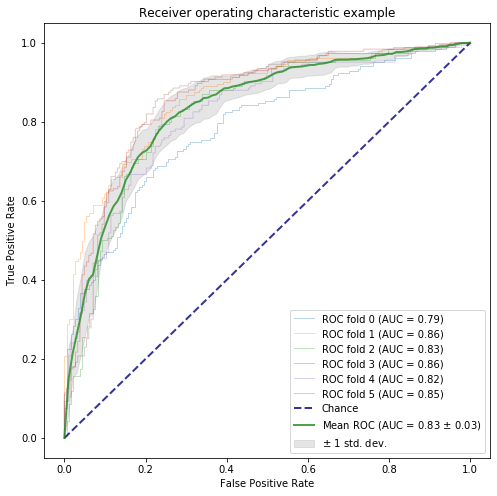

In [39]:
cv = StratifiedKFold(n_splits = 6)
classifier = SVC(kernel = 'linear', probability = True)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

X = XBalSc
y = YBal

fig, ax = plt.subplots(figsize = [8, 8])
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='navy',
        label='Chance', alpha= 0.8)

mean_tpr = np.mean(tprs, axis = 0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color = 'forestgreen',
        label = r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw = 2, alpha = 0.8)

std_tpr = np.std(tprs, axis = 0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color = 'grey', alpha = 0.2,
                label = r'$\pm$ 1 std. dev.')

ax.set(xlim = [-0.05, 1.05], ylim = [-0.05, 1.05],
       title = "Receiver operating characteristic example")
ax.legend(loc = "lower right")
plt.show()

### S8: 
- Q: Which pair of classes is the one with the highest classification accuracy? **Forest vs Highway**
- Q: Which pair of classes is the one with the lowest classification accuracy? **Industrial vs Residential (without PCA)**

(Also, below, will a neural network do better?) 

In [0]:
from keras.models import Sequential
from keras.layers import Dense

First, PCA to it make it manageable. 

In [118]:
NUM_COMP = 60

scaler = StandardScaler()
scaler.fit(dataMat)
X = scaler.transform(dataMat)

pca = PCA(n_components = NUM_COMP)
pcaMdl = pca.fit(X)
pcaCoor = pcaMdl.transform(X)

print(pcaCoor.shape)

(2700, 60)


Second, preparing the Y. 

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels)

Third, getting a baseline. 

In [119]:
from keras.wrappers.scikit_learn import KerasClassifier

def create_baseline():
	model = Sequential()
	model.add(Dense(60, input_dim = 60, activation = 'relu'))
	model.add(Dense(1, activation = 'sigmoid'))
	model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
	return model

estimator = KerasClassifier(build_fn = create_baseline, epochs = 100, batch_size = 5, verbose = 0)
kfold = StratifiedKFold(n_splits = 10, shuffle=True)
results = cross_val_score(estimator, pcaCoor, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 86.93% (2.34%)


Fourth, a bigger model. 

In [122]:
def create_larger():
	model = Sequential()
	model.add(Dense(60, input_dim = 60, activation='relu'))
	model.add(Dense(30, activation = 'relu'))
	model.add(Dense(1, activation = 'sigmoid'))
	model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
	return model

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn = create_larger, epochs = 100, batch_size = 5, verbose = 0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits = 10, shuffle = True)
results = cross_val_score(pipeline, pcaCoor, encoded_Y, cv = kfold)
print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Larger: 87.70% (1.11%)


Fifth, a smaller model. 

In [123]:
def create_smaller():
	model = Sequential()
	model.add(Dense(30, input_dim = 60, activation = 'relu'))
	model.add(Dense(1, activation = 'sigmoid'))
	model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
	return model

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn = create_smaller, epochs = 100, batch_size = 5, verbose = 0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits = 10, shuffle = True)
results = cross_val_score(pipeline, pcaCoor, encoded_Y, cv = kfold)
print("Smaller: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Smaller: 86.37% (1.82%)


These work but the difference between fitting a larger or smaller network is negligible—though all do well compared to SVM. 